In [1]:
import numpy as np
from scipy.optimize import Bounds, LinearConstraint, minimize, LinearConstraint

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

## MFMC Estimator for Sobol' Sensitivity Indicies

The variance of the MFMC variance estimator is given by 
\begin{align}\label{MSE-MFMC}
    \mathbb{V}\mathrm{ar}[\hat{V}_{\mathrm{mf}}] &= \frac{1}{m_{1}} \left(\delta_{1} - \frac{m_{1} - 3}{m_{1} -1} \sigma_{1}^{4}\right)\\  \nonumber
    &+ \sum_{k=2}^{K} \alpha_{k}^2 \left( \frac{1}{m_{k-1}} (\delta_{k} - \frac{m_{k-1} - 3}{m_{k-1} -1} \sigma_{k}^{4}) -\frac{1}{m_{k}} (\delta_{k} - \frac{m_{k} -3}{m_{k}-1} \sigma_{k}^{4})\right)\\ \nonumber
    &+ 2 \sum_{k=2}^{K} \alpha_{k} \left(\frac{1}{m_{k}}(q_{1, k} \tau_{1} \tau_{k} + \frac{2}{m_{k}-1} \rho_{1, k}^2 \sigma_{1}^2 \sigma_{k}^2) -\frac{1}{m_{k-1}}(q_{1, k} \tau_{1}\tau_{k} + \frac{2}{m_{k-1}-1} \rho_{1, k}^{2}\sigma_{1}^{2} \sigma_{k}^{2})\right), 
\end{align}
where $\rho_{k, 1} = \frac{\mathbb{C}\mathrm{ov}[ f^{(k)}(X), f^{(1)}(X)]}{\sigma_{k}\sigma_{1}}$ is the PCC between $f^{(k)}(X)$ and $f^{(1)}(X)$, $\sigma_{k}$ is the standard deviation of $f^{(k)}(X)$, $\delta_{k}$ is the fourth moment of $f^{(k)}(X)$, $\tau_{k}$ is the standard deviation of $g^{(k)}(X) = (f^{(k)}(X) - \mathbb{E}[f^{(k)}(X)])^2$ and $q_{k, 1} =\frac{\mathbb{C}\mathrm{ov}[g^{(k)}(X), g^{(1)}(X)]}{\tau_{k}\tau_{1}}$. 

Thus, the nonlinear optimization problem is given by
\begin{equation*}
    \min_{\substack{\alpha_{2}, \ldots, \alpha_{K}\in \mathbb{R}\\ m_{1}, \ldots, m_{K} \in \mathbb{R}}} \mathbb{V}\mathrm{ar}[\hat{V}_{\mathrm{mf}}] \qquad \mathrm{s.t.} \qquad 0 < m_{1} \leq m_{2} \leq \ldots \leq m_{K} \qquad \mathrm{and}  \qquad \sum_{k=1}^{K} w_{k}m_{k} = B.
\end{equation*}

Note that the nonlinear optimization problem depends on the model statistics $(\rho_{1, k}, \sigma_{k}, \delta_{k}, q_{1, k}, \tau_{k})$, resulting in *optimization under uncertainty*, where the objective function has up to fourth-order dependencies on the model statistics.

In [26]:
# load LHS samples 
samples = np.load("samples/test_mfmc_50.npy")
N, d = np.shape(samples)
print("number of samples = ", N)
print("number of variables = ", d)

number of samples =  50
number of variables =  9


In [35]:
QoI = np.zeros(N)

In [56]:
for ii in range(N):
    # load the solution of the highest-fidelity model
    sol = np.load("ensemble/f1/sample_" + str(ii) + "/sol.npy")
    # load the pde object for this run to obtain rho0 (reference density value/ normalizing constant)
    pde = np.load("ensemble/f1/sample_" + str(ii) + "/pde.npy",allow_pickle=True).item()
    # obtain rho0
    rho0 = pde["physicsparam"][19]
    # QoI is the density at 350km altitude at the last timestamp
    QoI[ii] = np.exp(sol[2, 0, 30, -1]).flatten("F")*float(rho0)

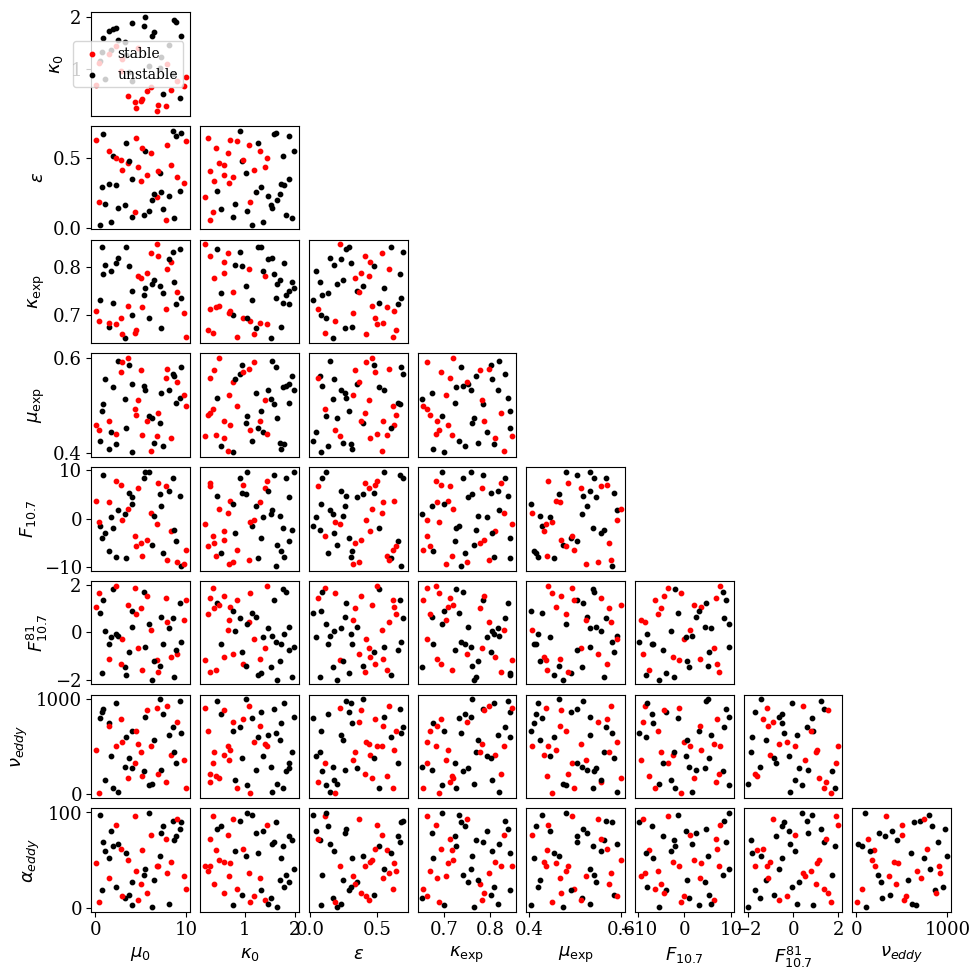

In [61]:
fig, ax = plt.subplots(ncols=d-1, nrows=d-1, figsize=(10, 10))

for jj in range(d-1):
    for ii in range(d-1):
        if jj <= ii:
            for kk in range(N):
                if np.isfinite(QoI[kk]):
                    color = "red"
                else:
                    color = "black"
                ax[ii, jj].scatter(samples[kk, jj], samples[kk, ii+1], c=color, s=10)
            if ii != 7:
                ax[ii, jj].set_xticks([])
            if jj != 0:
                ax[ii, jj].set_yticks([])
        else:
            ax[ii, jj].set_xticks([])
            ax[ii, jj].set_yticks([])
            ax[ii, jj].spines['top'].set_visible(False)
            ax[ii, jj].spines['right'].set_visible(False)
            ax[ii, jj].spines['bottom'].set_visible(False)
            ax[ii, jj].spines['left'].set_visible(False)

ax[-1, 0].set_xlabel(r"$\mu_{0}$")
ax[-1, 1].set_xlabel(r"$\kappa_{0}$")
ax[-1, 2].set_xlabel(r"$\epsilon$")
ax[-1, 3].set_xlabel(r"$\kappa_{\mathrm{exp}}$")
ax[-1, 4].set_xlabel(r"$\mu_{\mathrm{exp}}$")
ax[-1, 5].set_xlabel(r"$F_{10.7}$")
ax[-1, 6].set_xlabel(r"$F_{10.7}^{81}$")
ax[-1, 7].set_xlabel(r"$\nu_{eddy}$")

ax[0, 0].set_ylabel(r"$\kappa_{0}$")
ax[1, 0].set_ylabel(r"$\epsilon$")
ax[2, 0].set_ylabel(r"$\kappa_{\mathrm{exp}}$")
ax[3, 0].set_ylabel(r"$\mu_{\mathrm{exp}}$")
ax[4, 0].set_ylabel(r"$F_{10.7}$")
ax[5, 0].set_ylabel(r"$F_{10.7}^{81}$")
ax[6, 0].set_ylabel(r"$\nu_{eddy}$")
ax[7, 0].set_ylabel(r"$\alpha_{eddy}$")

ax[0, 0].scatter(np.nan, np.nan, c="red", label="stable", s=10)
ax[0, 0].scatter(np.nan, np.nan, c="black", label="unstable", s=10)
ax[0, 0].legend(fontsize=10)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("../figs/QoI_in_parameter_space_preliminary_refinement_of_priors_old.png", dpi=500)
plt.show()